# A 2-Hours Seminar about [InterCom](https://github.com/Tecnologias-multimedia/intercom)

## Contents

1. What is InterCom?
2. De-jittering through buffering.
3. Decreasing the bit-rate through compression.
4. A simple bit-rate control through quantization.
5. Removing intra-frame redundancy.
6. Removing intra-channel redundancy.
7. Future developments.

## 1. What is InterCom?
InterCom is a real-time intercommunicator (currently, only transmitting audio). The sequence of [frames](https://python-sounddevice.readthedocs.io/en/0.3.12/api.html) (two stereo samples) is splitted into chunks and each one is transmitted in an [UDP](https://en.wikipedia.org/wiki/User_Datagram_Protocol) packet.

### A [minimal](https://tecnologias-multimedia.github.io/study_guide/minimal/) implementation

In [ ]:
# Interrupt with: Kernel -> Interrupt
!python ~/intercom/minimal.py --show_stats

## 2. De-[jitter](https://en.wikipedia.org/wiki/Jitter)ing through [buffering](https://tecnologias-multimedia.github.io/study_guide/buffering/)

### Which is the latency and jitter in my host?

In [ ]:
!ping -c 10 localhost

Too good to do simulations using `localhost` :-/

### Which is the expected Internet latency?

In [ ]:
!ping -c 10 8.8.8.8 # Google DNS

### Let's increases latency and jitter for the `localhost` link
* Latency = 20 ms.
* Jitter = 5 ms.
* Correlation between RTTs = 0.25 (<1.0).
* Statistical distribution of the RTTs = normal.

In [ ]:
# Remember to add "your_username_here ALL=(ALL) NOPASSWD: ALL" to the end of /etc/sudoers.
# Notice that these times express RTTs, not simple one-way lantencies.
!tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay 20ms 5ms 25% distribution normal
!tc qdisc show dev lo

### (Optional) Remove `tc` rule

In [ ]:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

### Let's see ... now

In [ ]:
!ping -c 10 localhost

Better for our simulations.

### Let's listen again to minimal

In [ ]:
!python ~/intercom/minimal.py --show_stats

Quite bad :-/ The chunks don't arrive with a constant cadence to the receiver :

![Buffering](https://tecnologias-multimedia.github.io/study_guide/buffering/graphics/timelines.svg)

### And finally, let's hidden the jitter

In [ ]:
!python ~/intercom/buffer.py --show_stats # 100 ms is the default buffering time

Much better!

## 3. Decreasing the transmission bit-rate through compression

### Estimation of the [throughput](https://en.wikipedia.org/wiki/Throughput) of the `localhost` link
Notice that the following technique depends heavely on the packet size, that using ping is limited to 64 KB (including the IP header). For this reason, the results can be only approximated :-/

In [ ]:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo
!ping -c 1 -s 65527 localhost

In [ ]:
!printf "Gbps = "
!echo 65527*8/0.147/2/1000/1000 | bc -l

Too high! We need harder conditions for testing InterCom that without compression requires

\begin{equation}
\frac{44100\frac{\text{frames}}{\text{second}}\times 2\frac{\text{samples}}{\text{frame}}\times 2\frac{\text{bytes}}{\text{sample}}\times 8\frac{\text{bits}}{\text{byte}}}{1000} = 1411.2 ~\text{kbps}
\end{equation}

### Let's simulate (also) a throughput of 200 kbps

In [ ]:
# Definitive rules for the rest of experiments
!sudo tc qdisc add dev lo root handle 1: netem delay 20ms 5ms 25% distribution normal
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate 200kbit burst 1024kbit limit 1024kbit

### (Optional) Remove the previous `tc` rules

In [ ]:
!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!tc qdisc show dev lo

In [ ]:
!ping -c 1 -s 65507 localhost

In [ ]:
print("Throughput =", 65507*8/522/2, "kbps")

###  Insufficient throughput?
... or too many kbps?

In [ ]:
!python ~/intercom/buffer.py --show_stats

### [Compression](https://tecnologias-multimedia.github.io/study_guide/compress/) using [DEFLATE](https://en.wikipedia.org/wiki/DEFLATE)

The chunks can be compressed with [LZSS](https://en.wikipedia.org/wiki/Lempel-Ziv-Storer-Szymanski), that is based on [LZ77](https://github.com/vicente-gonzalez-ruiz/LZ77) and [Huffman Coding](https://vicente-gonzalez-ruiz.github.io/Huffman_coding/).

We have choosen this text compressor codec because:
1. It's fast.
2. Works well when repeated strings are found at the input.
3. I's available with [The Standard Python Library](https://docs.python.org/3/library/) ([zlib](https://docs.python.org/3/library/zlib.html)).

In [ ]:
!python ~/intercom/compress.py --show_stats

Notice that a lot of chunks are still lost. DEFLATE is not enough!

## 4. A simple [bit-rate "control"](https://tecnologias-multimedia.github.io/study_guide/quantization/) through [quantization](https://github.com/vicente-gonzalez-ruiz/quantization/blob/master/digital_quantization.ipynb)

Quantization removes the less relevant information (mainly [electronic noise](https://en.wikipedia.org/wiki/Noise_(electronics)) ...) and helps to increase the [compression ratio](https://en.wikipedia.org/wiki/Compression_ratio). In lossy signal compression, [dead-zone quantizers](https://github.com/vicente-gonzalez-ruiz/quantization/blob/master/digital_quantization.ipynb) are commonly used because they tend to generate 0's that like to entropy compressors.

We use the quantizer
\begin{equation}
  k = \text{sgn}(x) \max\left(0, \left\lfloor \frac{\left| x \right|}{\Delta} + \frac{1}{2}\right\rfloor\right),
\end{equation}
where $k$ is the quantization index, and $\Delta$ is the quantization step. The dequantizer is defined by:
\begin{equation}
  y = \Delta k.
\end{equation}

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np
import sounddevice as sd
from scipy import signal

In [2]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

In [3]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

In [4]:
x = np.linspace(-8, 8, 500) # Input samples
k2 = quantizer(x, quantization_step = 2)
y2 = dequantizer(k2, quantization_step = 2)
k3 = quantizer(x, quantization_step = 3)
y3 = dequantizer(k3, quantization_step = 3)

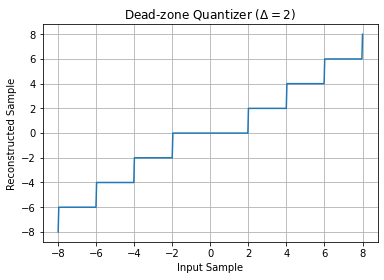

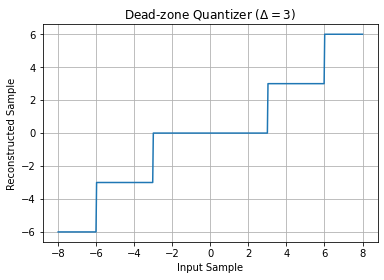

In [5]:
plot(x, y2, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(2))
plot(x, y3, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(3))

In [6]:
def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

In [8]:
x = np.arange(start = -8, stop = 9, step = 1)
k, y = q_deq(x, quantization_step = 3)
print("    Original samples =", x)
print("Quantization indexes =", k)
print(" Dequantized samples =", y)

    Original samples = [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8]
Quantization indexes = [-2 -2 -2 -1 -1 -1  0  0  0  0  0  1  1  1  2  2  2]
 Dequantized samples = [-6 -6 -6 -3 -3 -3  0  0  0  0  0  3  3  3  6  6  6]


In InterCom, we lossely "control" the bit-rate because a strict bit-rate control through the variation of the quantization step $\Delta$ is computationally intensive (we must determine the [Rate/Distortion curve](https://en.wikipedia.org/wiki/Rate%E2%80%93distortion_theory) of the current chunk to find $\Delta$ before to quantize, compress and send it) and it's hard to compute in real-time . For this reason, the current implementation estimates the number of lost chunks per second (in the last second) and use this information to increase or decrease the quantization step for the chunks (of the next second).

In [9]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


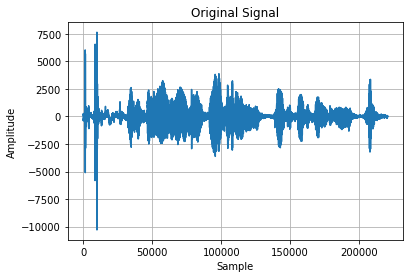

In [10]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Sample", "Amplitude", "Original Signal")

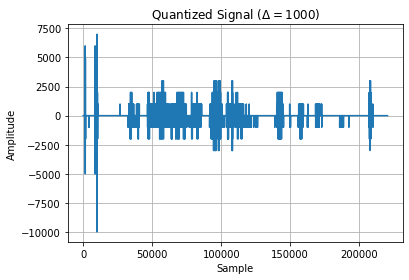

In [11]:
quantization_step = 1000
k, y = q_deq(x, quantization_step = 1000)
sd.play(y)
plot(np.linspace(0, len(y)-1, len(y)), y, "Sample", "Amplitude", "Quantized Signal ($\Delta={}$)".format(quantization_step))

In [12]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def RD_curve(x):
    points = []
    for q_step in range(1, 32768, 32):
        k, y = q_deq(x, q_step)
        rate = entropy_in_bits_per_symbol(k)
        distortion = RMSE(x, y)
        points.append((rate, distortion))
    return points

In [13]:
RD_points = RD_curve(x)

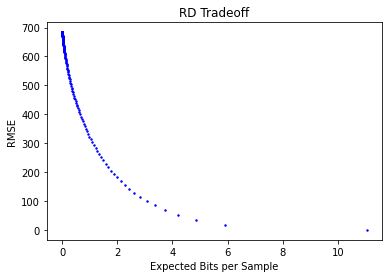

In [14]:
plt.title("RD Tradeoff")
plt.xlabel("Expected Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*RD_points), s=2, c='b', marker="o")
plt.show()

### Let's listen to the quantizer :-)

In [ ]:
!python ~/intercom/br_control.py --show_stats

## 5. [Spatial (inter-channel) decorrelation](https://tecnologias-multimedia.github.io/study_guide/spatial_decorrelation/)
The samples of a (stereo) frame tend to have similar amplitudes. For this reason, we apply [Mid/Side stereo coding](https://en.wikipedia.org/wiki/Joint_encoding#M/S_stereo_coding) (before quantization).

* The MST (Mid/Side Transform) analysis transform
\begin{equation}
  w = Kx = \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}x,
  \label{eq:forward_transform_matrix_form}
\end{equation}
that can be also written as
\begin{equation}
  \begin{bmatrix}
    w_0 \\
    w_1
  \end{bmatrix}
  = 
  \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
  \begin{bmatrix}
    x_0 \\
    x_1
  \end{bmatrix}, \tag{1}
\end{equation}
where $x$ is a stereo frame, $K$ is the (forward or analysis)
transform matrix and $w=\begin{bmatrix} w_0 & w_1\end{bmatrix}^{\text
  T}$ is the corresponding [decomposition](https://en.wikipedia.org/wiki/Discrete_wavelet_transform#Example_in_image_processing).
  
* The synthesis transform is
\begin{equation}
  x = K^{-1}w
  \label{eq:inverse_transform}
\end{equation}
can be found from Eq. (1), where we
get that
\begin{equation}
  \begin{array}{rcl}
  w_0 & = & x_0 + x_1\\
  w_1 & = & x_0 - x_1.
  \end{array}
\end{equation}
By solving $x_0$ (adding) and $x_1$ (substracting) in
these equations, we obtain that
\begin{equation}
  \begin{array}{rcl}
  x_0 & = & \frac{1}{2}(w_0 + w_1)\\
  x_1 & = & \frac{1}{2}(w_0 - w_1),
  \end{array}
\end{equation}
that in matrix form becomes
\begin{equation}
  \begin{bmatrix}
    x_0 \\
    x_1
  \end{bmatrix}
  = \frac{1}{2}
  \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
  \begin{bmatrix}
    w_0 \\
    w_1
  \end{bmatrix}.
\end{equation}

Therefore,
\begin{equation}
  x = K^{-1}w = \frac{1}{2}K^{\text T}w = \frac{1}{2}Kw = \frac{1}{2}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}w.
  \label{eq:inverse_transform_matrix_form}
\end{equation}

In [15]:
def plot(y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, len(y))
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

In [55]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


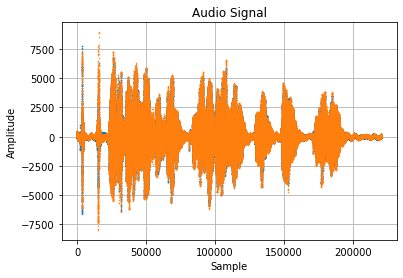

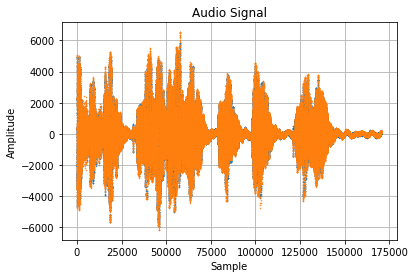

In [56]:
plot(x, "Sample", "Amplitude", "Audio Signal")
x = x[50000:]
plot(x, "Sample", "Amplitude", "Audio Signal")
sd.play(x)

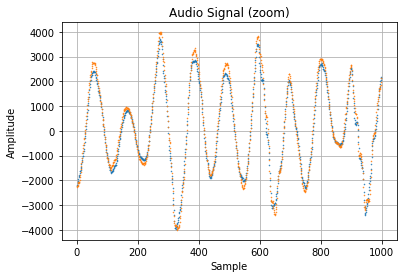

In [57]:
chunk = x[101000:102000]
plot(chunk, "Sample", "Amplitude", "Audio Signal (zoom)")

In [58]:
def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

In [59]:
w = MST_analyze(x)

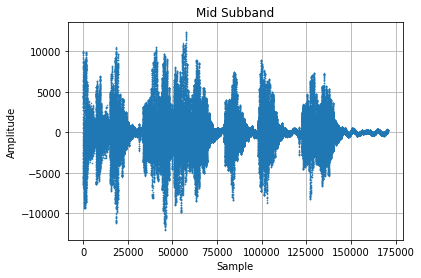

In [60]:
plot(w[:, 0], "Sample", "Amplitude", "Mid Subband")
sd.play(w[:, 0].astype(np.int16))

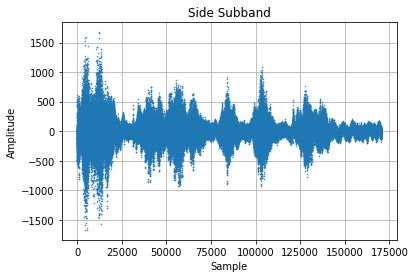

In [61]:
plot(w[:, 1], "Sample", "Amplitude", "Side Subband")
sd.play(w[:, 1].astype(np.int16))

In [62]:
K1 = np.array([1.0, 1.0])
w1, h1 = signal.freqz(K1, fs=44100)
K2 = np.array([1.0, -1.0])
w2, h2 = signal.freqz(K2, fs=44100)

<ipython-input-63-5632b4c1b6be>:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20 * np.log10(abs(h2)), 'b')


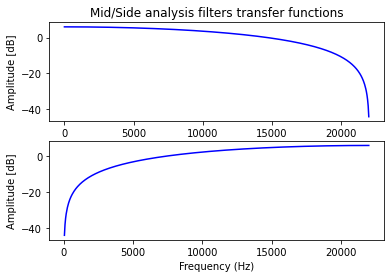

In [63]:
plt.subplot(211)
plt.title('Mid/Side analysis filters transfer functions')
plt.plot(w1, 20 * np.log10(abs(h1)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.subplot(212)
plt.plot(w2, 20 * np.log10(abs(h2)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.show()

In [64]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def q_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    return RD_points

def MST_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_data = MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

In [65]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)

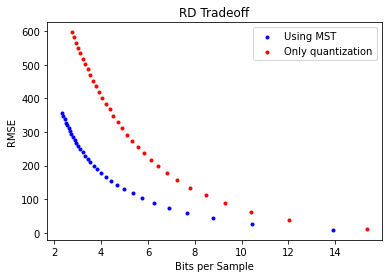

In [66]:
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='Using MST')
plt.scatter(*zip(*q_RD_points), c='r', marker=".", label='Only quantization')
plt.legend(loc='upper right')
plt.show()

### Result of aplying the MST to InterCom

In [67]:
!python ~/intercom/intra_frame_decorrelation.py --show_stats

Running Intra_frame_decorrelation.__init__
Running BR_Control__verbose.__init__
Running BR_Control.__init__
Running Compression__verbose.__init__
Running Compression.__init__
Running Buffering__verbose.__init__
Running Buffering.__init__
Running Minimal__verbose.__init__
Running Minimal.__init__
SECONDS_PER_CYCLE = 1
chunks_per_cycle = 43.06640625
frames_per_cycle = 44100
buffering_time = 100 miliseconds
chunks_to_buffer = 5
InterCom (Compression) is running
(minimum) quantization_step = 128

InterCom parameters:

Namespace(buffering_time=100, destination_address='localhost', destination_port=4444, frames_per_chunk=1024, frames_per_second=44100, input_device=None, list_devices=False, listening_port=4444, minimal_quantization_step=128, output_device=None, show_samples=False, show_stats=True)

Using device:

  0 HDA Intel PCH: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
  1 HDA Intel PCH: HDMI 1 (hw:0,7), ALSA (0 in, 8 out)
  2 HDA Intel PCH: HDMI 2 (hw:0,8), ALSA (0 in, 8 out)
  3 HDA Intel PCH

    9      44      44    1068    1068   12   30 ['180094623', '205977037'] ['10.0', ' 9.9'] ['12.3', '12.3'] 128 ['55459', '57396'] [' -3', ' -3'] ['356706', '347674']
Avgs:      44      44    1012    1012   14   33 ['183178672', '189987170'] [' 9.9', ' 9.9'] ['11.9', '11.9']     ['48161', '52276'] ['  3', '  3'] ['310303', '326619']
cycle  mesgs.  mesgs.    kbps    kbps %CPU %CPU                   variance          entropy              BPS   Q        RMSE/sample        SNR[dB]        LH variance
         sent   recv.    sent   recv.    Global                                                                              10^4 *                                  

   10      44      44    1061    1061   11   22 ['174248249', '191586741'] [' 9.9', '10.0'] ['12.3', '12.3'] 128 ['55831', '59527'] [' -3', ' -3'] ['356669', '348011']
Avgs:      44      44    1017    1017   14   32 ['182285630', '190147127'] [' 9.9', ' 9.9'] ['12.0', '11.9']     ['48928', '53001'] ['  3', '  2'] ['314940', '3287

## 6. [Temporal (intra-channel) decorrelation](https://tecnologias-multimedia.github.io/study_guide/temporal_decorrelation/)
* The samples of each channel exhibit temporal redundancy. Therefore, we use a [Discrete Wavelet Transform (DWT)](https://tecnologias-multimedia.github.io/study_guide/temporal_decorrelation/) to exploit it (before quantization).

* The DWT can be implemented with PRFB's:
![DWT](https://tecnologias-multimedia.github.io/study_guide/temporal_decorrelation/graphics/cascade.svg)
where $l$ stands for low-frequency subband, and $h$ for high-frequency subband. $\downarrow 2$ represents a subsampling of one of each two samples, and $\uparrow 2$ the insertion of a 0 where the downsampler discarded a sample.

* Depending on how:
    1. $\phi$ (the analysis scaling function (low-pass frequency analysis filter)),
    2. $\psi$ (the analysis wavelet function (hihg-pass frequency analysis filter),
    3. $\tilde\phi$ (the synthesis scaling function (low-pass frequency synthesis filter),
    4. and $\tilde\psi$ the synthesis wavelet function (high-pass frequency synthesis filter))
are defined, a different DWT is computed.

* The DWT generates the decomposition:
 \begin{equation*}
    | l^s_0 | h^s_0 | h^{s-1}_0 h^{s-1}_1 | h^{s-2}_0 h^{s-2}_1 h^{s-2}_2 h^{s-2}_3 | \cdots | h^1_0 h^1_1 \cdots h^1_{2^{n-1}-1} |,
  \end{equation*}
where $s$ represents the subband index, and each subband contains a set of coefficients.

* The [DWT in matrix](https://cseweb.ucsd.edu/classes/fa17/cse166-a/lec13.pdf) form.

### Let's see the DWT in action
Go to the shell and run:
```
pyenv activate tm
cd
python intercom/test/sounddevice/plot_input_stereo.py &
python intercom/test/transforms/rfft_hamming.py &
python intercom/test/transforms/dwt5.py &
python intercom/test/sounddevice/play_sine.py 440
```

### Exploring DWTs

In [68]:
import sounddevice as sd
import pywt
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab

In [47]:
N = 512
levels = 4
#wavelet_name = "haar"
wavelet_name = "db5"
#wavelet_name = "db20"
#wavelet_name = "bior2.2"
#wavelet_name = "rbio2.2"
wavelet = pywt.Wavelet(wavelet_name)

In [48]:
def energy_of_signal(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))

def spectrum(i):
    zeros = np.zeros(N)
    decomposition = pywt.wavedec(zeros, wavelet=wavelet, level=levels, mode="per")
    coefficients, slices = pywt.coeffs_to_array(decomposition)
    coefficients[i] = 1
    decomposition = pywt.array_to_coeffs(coefficients, slices, output_format="wavedec")
    samples = pywt.waverec(decomposition, wavelet=wavelet, mode="per")
    coefs = np.fft.rfft(samples)
    spectrum = np.sqrt(coefs.real*coefs.real + coefs.imag*coefs.imag)
    pylab.plot(np.linspace(0, len(spectrum)-1, len(spectrum)), spectrum)
    energy = energy_of_signal(samples)
    if i <= (N>>levels):
        type = "scaling f."
    else:
        type = "wavelet f."
    pylab.plot(np.linspace(0, len(samples)-1, len(samples)), samples, label=f"{i} ({energy:3.2f}) {type}")
    pylab.legend(loc='upper right')
    pylab.show()

In [50]:
interact(spectrum, i=widgets.IntSlider(min=0, max=N-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='i', max=511), Output()), _dom_classes=('widget-interact'…

### Let's quantify the DWT contribution

In [69]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def DWT_analyze(x, levels):
    coefs = np.empty(x.shape, dtype=np.int32)
    decomposition_0 = pywt.wavedec(x[:, 0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(x[:, 1], wavelet=wavelet, level=levels, mode="per")
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int16)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int16)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int16)
    return samples

def DWT_RD_curve(data, levels):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(data)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        k, y = q_deq(DWT_coefs, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        MST_coefs = DWT_synthesize(y, slices)
        reconstructed_data = MST_synthesize(MST_coefs)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

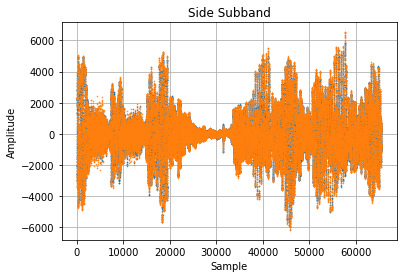

In [70]:
x = x[:65536]
plot(x, "Sample", "Amplitude", "Side Subband")
sd.play(x.astype(np.int16))

In [71]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)
DWT_RD_points = DWT_RD_curve(x, levels = 5)

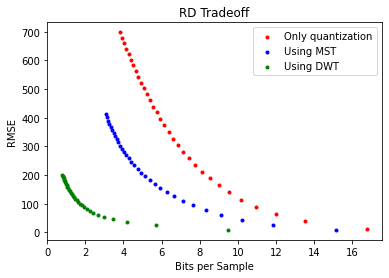

In [72]:
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*q_RD_points), c='r', marker=".", label='Only quantization')
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='Using MST')
plt.scatter(*zip(*DWT_RD_points), c='g', marker=".", label='Using DWT')
plt.legend(loc='upper right')
plt.show()

### Result of aplying the DWT to InterCom

In [ ]:
!python ~/my-intercom/intra_channel_decorrelation.py --show_stats

## 7. Future work
1. Currently, quantization minimizes the MSE (Mean Square Error). [Perceptual](https://en.wikipedia.org/wiki/Psychoacoustics) quantization should increase the compression ratio without increasing the perceived distortion.
2. Transmit [video](https://en.wikipedia.org/wiki/Video).